In [145]:
import numpy as np
import matplotlib.pyplot as plt

In [146]:
# Load the dataset
# X -> features, y -> label
def load_dtrain13(file):
    dtrain13 = np.loadtxt(file)
    y = dtrain13[:, 0].astype(int)
    X = dtrain13[:, 1:]
    return X, y

In [147]:
# Load each dataset dtrain13_50, dtrain13_100, dtrain13_200, dtrain30_400
datasets = {}
ns = [50, 100, 200, 400]
for n in ns:
    file = f"dtrain13_{n}.dat"
    X,y = load_dtrain13(file)
    datasets[n] = {"X": X, "y": y}

In [148]:
def construct_graph(X):
    n = len(X)
    
    # Calculate 3-NN for each vertex
    neighbours = {i: [] for i in range(n)}

    for i in range(0, n):
        for j in range(0, n):
            if i == j:
                continue
            diff = X[i] - X[j]
            d2 = np.dot(diff, diff)
            neighbours[i].append((j, d2))
        neighbours[i] = sorted(neighbours[i], key=lambda x: x[1])[:3]

    # Construct adjacency matrix using the 3-NN dict
    W = np.zeros((n,n))

    for node in neighbours:
        for j, _ in neighbours[node]:
            W[node, j] = 1
            W[j, node] = 1 # 1 if i neighbours of j or j neighbour of i
    return W
            

In [149]:
def construct_laplacian_matrix(W):
    D = np.diag(np.sum(W, axis=1))

    L = D - W
    return L

In [150]:
def laplacian_interpolation(dataset, L):
    W = construct_graph(dataset['X'])
    laplacian = construct_laplacian_matrix(W)

    n = W.shape[0]

    # Conceptually: Write L as blocks of L_UU and L_UL
    L_idx = np.concatenate([L['1'], L['3']])
    all_idx = np.arange(n)
    U_idx = np.setdiff1d(all_idx, L_idx)
    L_UU = laplacian[np.ix_(U_idx, U_idx)]
    L_UL = laplacian[np.ix_(U_idx, L_idx)]

    # Get the label values in the order of L_idx (u_L)
    y_1 = -np.ones(len(L['1']), dtype=float)
    y_3 = +np.ones(len(L['3']), dtype=float)
    u_L = np.concatenate([y_1, y_3])

    # Solve L_UU u_U = -L_UL u_L
    eps = 1e-6
    u_U = np.linalg.solve(L_UU + eps * np.eye(L_UU.shape[0]), -L_UL @ u_L)

    # Reassemble full u
    u = np.zeros(n, dtype=float)
    u[L_idx] = u_L
    u[U_idx] = u_U

    # Predictions via sign
    y_hat_pm1 = np.sign(u)
    y_hat_pm1[y_hat_pm1 == 0] = 1
    y_hat = np.where(y_hat_pm1 < 0, 1, 3)

    # Empirical generalisation error over [m]\L 
    err = np.mean(y_hat[U_idx] != dataset['y'][U_idx])
    return err
    


In [151]:
def laplacian_kernel_interpolation(dataset, L):
    W = construct_graph(dataset['X'])
    laplacian = construct_laplacian_matrix(W)
    laplacian_pinv = np.linalg.pinv(laplacian)

    L_idx = np.concatenate([L['1'], L['3']])
    y_1 = -np.ones(len(L['1']), dtype=float)
    y_3 = +np.ones(len(L['3']), dtype=float)
    y_L = np.concatenate([y_1, y_3])

    # Compute Kernel matrix as the block of L+ of only labelles indices
    K = laplacian_pinv[np.ix_(L_idx, L_idx)]
    K_pinv = np.linalg.pinv(K)
    alpha = K_pinv @ y_L

    # Compute v vector
    v = laplacian_pinv[:, L_idx] @ alpha

    # Predictions via sign
    y_hat_pm1 = np.sign(v)
    y_hat_pm1[y_hat_pm1 == 0] = 1
    y_hat = np.where(y_hat_pm1 < 0, 1, 3)

    all_idx = np.arange(len(dataset['y']))
    U_idx = np.setdiff1d(all_idx, L_idx)
    
    # Empirical generalisation error over [m]\L 
    err = np.mean(y_hat[U_idx] != dataset['y'][U_idx])
    return err




In [152]:
# Randomly sample (without replacement) indices which are labelled 1 and 3
# 1-labels appear in the first half of all datasets
# 3-lables appear in the second half of all datasets
SEED = 12345
rng = np.random.default_rng(SEED)

def random_sample_labelled_examples(num_total, num_samples):
    half = num_total // 2
    labels_1 = rng.choice(half, size=num_samples, replace=False)
    labels_3 = rng.choice(np.arange(half, num_total), size=num_samples, replace=False)
    return labels_1, labels_3

In [153]:
ls = [1, 2, 4, 8, 16]
ns = [50, 100, 200, 400]
errLIs  = {n: {l: [] for l in ls} for n in ns}
errLKIs = {n: {l: [] for l in ls} for n in ns}

for n in ns:
    dataset = datasets[n]
    for l in ls:
        for run in range(20):
            labels_1, labels_3 = random_sample_labelled_examples(n*2, l)
            L = {'1':labels_1, '3': labels_3 }
            errLI = laplacian_interpolation(dataset, L)
            errLKI = laplacian_kernel_interpolation(dataset, L)
            errLIs[n][l].append(errLI)
            errLKIs[n][l].append(errLKI)    
        print(f"Laplacian Interpolation: Error for {n} data points per label and {l} known labels (per class): {np.mean(errLIs[n][l])} +- {np.std(errLIs[n][l])}")
        print(f"Laplacian Kernel Interpolation: Error for {n} data points per label and {l} known labels (per class): {np.mean(errLKIs[n][l])} +- {np.std(errLKIs[n][l])}")

Laplacian Interpolation: Error for 50 data points per label and 1 known labels (per class): 0.2653061224489796 +- 0.1227462378260863
Laplacian Kernel Interpolation: Error for 50 data points per label and 1 known labels (per class): 0.09183673469387757 +- 0.05958694416594462
Laplacian Interpolation: Error for 50 data points per label and 2 known labels (per class): 0.14739583333333334 +- 0.10265967195801756
Laplacian Kernel Interpolation: Error for 50 data points per label and 2 known labels (per class): 0.06874999999999999 +- 0.04053140928821608
Laplacian Interpolation: Error for 50 data points per label and 4 known labels (per class): 0.08315217391304347 +- 0.06773012651551143
Laplacian Kernel Interpolation: Error for 50 data points per label and 4 known labels (per class): 0.05217391304347826 +- 0.02420767114273922


/var/folders/12/vkxv8hm12bn59_9k33xhbfs80000gn/T/ipykernel_61642/1582579665.py:21: RuntimeWarning: divide by zero encountered in matmul
  u_U = np.linalg.solve(L_UU + eps * np.eye(L_UU.shape[0]), -L_UL @ u_L)
/var/folders/12/vkxv8hm12bn59_9k33xhbfs80000gn/T/ipykernel_61642/1582579665.py:21: RuntimeWarning: overflow encountered in matmul
  u_U = np.linalg.solve(L_UU + eps * np.eye(L_UU.shape[0]), -L_UL @ u_L)
/var/folders/12/vkxv8hm12bn59_9k33xhbfs80000gn/T/ipykernel_61642/1582579665.py:21: RuntimeWarning: invalid value encountered in matmul
  u_U = np.linalg.solve(L_UU + eps * np.eye(L_UU.shape[0]), -L_UL @ u_L)
/var/folders/12/vkxv8hm12bn59_9k33xhbfs80000gn/T/ipykernel_61642/3702463144.py:17: RuntimeWarning: divide by zero encountered in matmul
  v = laplacian_pinv[:, L_idx] @ alpha
/var/folders/12/vkxv8hm12bn59_9k33xhbfs80000gn/T/ipykernel_61642/3702463144.py:17: RuntimeWarning: overflow encountered in matmul
  v = laplacian_pinv[:, L_idx] @ alpha
/var/folders/12/vkxv8hm12bn59_9k33xh

Laplacian Interpolation: Error for 50 data points per label and 8 known labels (per class): 0.04464285714285714 +- 0.012414674770603696
Laplacian Kernel Interpolation: Error for 50 data points per label and 8 known labels (per class): 0.042261904761904764 +- 0.007963742952535506


/var/folders/12/vkxv8hm12bn59_9k33xhbfs80000gn/T/ipykernel_61642/3702463144.py:14: RuntimeWarning: divide by zero encountered in matmul
  alpha = K_pinv @ y_L
/var/folders/12/vkxv8hm12bn59_9k33xhbfs80000gn/T/ipykernel_61642/3702463144.py:14: RuntimeWarning: overflow encountered in matmul
  alpha = K_pinv @ y_L
/var/folders/12/vkxv8hm12bn59_9k33xhbfs80000gn/T/ipykernel_61642/3702463144.py:14: RuntimeWarning: invalid value encountered in matmul
  alpha = K_pinv @ y_L


Laplacian Interpolation: Error for 50 data points per label and 16 known labels (per class): 0.04117647058823529 +- 0.012820291010413746
Laplacian Kernel Interpolation: Error for 50 data points per label and 16 known labels (per class): 0.03823529411764705 +- 0.014257881933577438
Laplacian Interpolation: Error for 100 data points per label and 1 known labels (per class): 0.051515151515151514 +- 0.030286190607201915
Laplacian Kernel Interpolation: Error for 100 data points per label and 1 known labels (per class): 0.04217171717171718 +- 0.007011840089350919
Laplacian Interpolation: Error for 100 data points per label and 2 known labels (per class): 0.03801020408163266 +- 0.010136896166482412
Laplacian Kernel Interpolation: Error for 100 data points per label and 2 known labels (per class): 0.03571428571428571 +- 0.009407698425809068
Laplacian Interpolation: Error for 100 data points per label and 4 known labels (per class): 0.04609375 +- 0.020720724306804796
Laplacian Kernel Interpolati

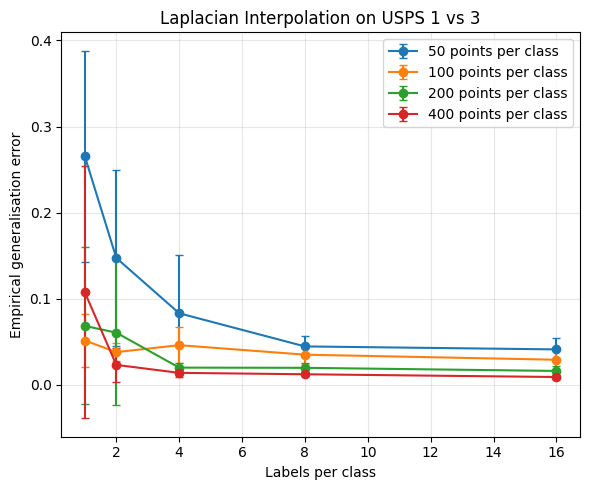

In [154]:
def plot_li_errors(errLIs, ls, ns, title_prefix="Laplacian Interpolation"):
    plt.figure(figsize=(6, 5))

    for n in ns:
        means = []
        stds = []
        for ell in ls:
            errs = np.array(errLIs[n][ell])
            means.append(errs.mean())
            stds.append(errs.std())
        means = np.array(means)
        stds = np.array(stds)

        plt.errorbar(
            ls, means, yerr=stds,
            marker='o', capsize=3, label=f"{n} points per class"
        )

    plt.xlabel("Labels per class")
    plt.ylabel("Empirical generalisation error")
    plt.title(f"{title_prefix} on USPS 1 vs 3")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

plot_li_errors(errLIs, ls=[1,2,4,8,16], ns=[50,100,200,400])


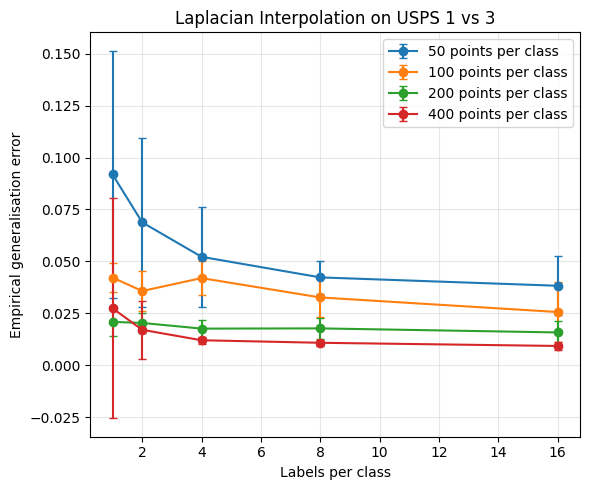

In [155]:
def plot_lki_errors(errLKIs, ls, ns, title_prefix="Laplacian Kernel Interpolation"):
    plt.figure(figsize=(6, 5))

    for n in ns:
        means = []
        stds = []
        for l in ls:
            errs = np.array(errLKIs[n][l])
            means.append(errs.mean())
            stds.append(errs.std())
        means = np.array(means)
        stds = np.array(stds)

        plt.errorbar(
            ls, means, yerr=stds,
            marker='o', capsize=3, label=f"{n} points per class"
        )

    plt.xlabel("Labels per class")
    plt.ylabel("Empirical generalisation error")
    plt.title(f"{title_prefix} on USPS 1 vs 3")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

plot_li_errors(errLKIs, ls=[1,2,4,8,16], ns=[50,100,200,400])